#  "UJ SN2019 Zadanie 2: Nocne Ptasie Wędrówki"

## Basic information for audio analysis

### Spectogram
- visual representation of sound
- representation of the spectrum of frequencies of a signal as it varies over time

__Spectogram attributes__:
- time [s] on X asis
- frequency [Hz]  on Y axis
- amplitude as shading/intensity (colour refers to lower-higher amplitude)

__Example spectogram generation:__
- approximated as a filterbank that results from a series of band-pass filters (analog processing)
- calculated from the time signal using the Fourier transform (digital processing) <br>
These two methods actually form two different time–frequency representations, but are equivalent under some conditions.

## Data representation

### Let's listen randomly choosen recording

In [1]:
import os
import IPython
filename = 'rec110.wav'
IPython.display.Audio(os.path.join('train', filename))

### Mel spectogram for recording
__Mel-scale__ - dependence between subjectively received pitch and objectively measured frequency in Hertz.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/Mel-Hz_plot.svg/2880px-Mel-Hz_plot.svg.png width="600">


Mel-scaled spectogram is generated using __librosa.feature.melspectrogram__. 
In my case, input to above function is a floating point time series representation. So that, spectrogram S is first computed, and then mapped onto the mel scale by __mel_f.dot(S**power)__. <br>
Filterbank matrix (an array of band-pass filters that separates the input signal into multiple components, each one carrying a single frequency sub-band of the original signal) is created to combine FFT bins into Mel-frequency bins.

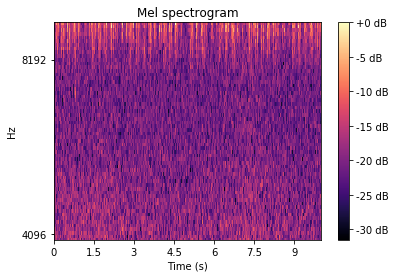

In [2]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

F_MIN = 4000
F_MAX = 9500

filename = 'rec1.wav'

def load_recording(filename, train=True):
    if train:
        file_path = os.path.join('train', filename)
    else:
        file_path = os.path.join('test', filename)
    y, sample_rate = librosa.core.load(os.path.join('train', filename), sr=None)
    return y, sample_rate


def get_mel_spectogram(time_series_representation, sample_rate, start_second=0, end_second=10, n_mels=60):
    time_series_representation = time_series_representation[int(start_second * sample_rate):int(end_second * sample_rate)]
    mel_spectrogram = librosa.feature.melspectrogram(y=time_series_representation, sr=sample_rate, n_mels=n_mels,
                                                     fmin=F_MIN, 
                                                     fmax=F_MAX)
    return mel_spectrogram, sample_rate


def plot_mel_spectrogram(spectrogram, sample_rate):
    librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max), sr=sample_rate, 
                             fmin=F_MIN, 
                             fmax=F_MAX,
                             y_axis='mel', x_axis='s')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')


y, sample_rate = load_recording(filename)
spectrogram, sample_rate = get_mel_spectogram(y, sample_rate)
plot_mel_spectrogram(spectrogram, sample_rate)

## Train, validation and test data preparation

In [3]:
def get_recording_with_list_of_seconds_where_bird_exist():
    rec_files = [filename for filename in os.listdir('train') if filename.endswith('.wav')]
    recordings = [filename.split(',')[0][:-4] for filename in rec_files]
    recording_second_mapping = {}
    for r in recordings:
        recording_second_mapping.setdefault(r, [])
    with open(os.path.join('train', 'labels.txt'), 'r') as f:
        for i, line in enumerate(f):
            if i != 0:
                recording_name = line.split(',')[0]
                start = int(float(line.split(',')[1]))
                stop = int(float(line.split(',')[2]))
                recording_second_mapping[recording_name].append(start)
                recording_second_mapping[recording_name].append(start)
    return recording_second_mapping

In [4]:
N_SECONDS = 10
INTERVAL_TIME_IN_SECONDS = 0.2

def load_train(recording_length=N_SECONDS):
    X_train, y_train = [], []
    N_SECONDS = 10
    recording_files = sorted([filename for filename in os.listdir('train') if filename.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    recording_second_mapping = get_recording_with_list_of_seconds_where_bird_exist()
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        for sec in range(recording_length):
            spectograms_for_one_second = []
            for i in np.arange(sec, sec+1, INTERVAL_TIME_IN_SECONDS):
                spectrogram, _ = get_mel_spectogram(y, sample_rate, start_second=i, end_second=i+INTERVAL_TIME_IN_SECONDS)
                spectograms_for_one_second.append(spectrogram)
            X_train.append(np.array(spectograms_for_one_second))
            if sec in recording_second_mapping[recording_file.split('.')[0]]:
                y_train.append([1]) #bird exists
            else:
                y_train.append([0]) #bird does not exist
    return np.array(X_train), np.array(y_train)


def load_test(recording_length=N_SECONDS):
    X_test, y_test = [], []
    recording_files = sorted([filename for filename in os.listdir('test') if filename.endswith('.wav')], key=lambda x: int(x.split('.')[0][3:]))
    recording_second_mapping = get_recording_with_list_of_seconds_where_bird_exist()
    for recording_file in recording_files:
        # get spectogram representation of recording
        y, sample_rate = load_recording(recording_file)
        for sec in range(recording_length):
            spectograms_for_one_second = []
            for i in np.arange(sec, sec+1, INTERVAL_TIME_IN_SECONDS):
                spectrogram, _ = get_mel_spectogram(y, sample_rate, start_second=i, end_second=i+INTERVAL_TIME_IN_SECONDS)
                spectograms_for_one_second.append(spectrogram)
            X_test.append(np.array(spectograms_for_one_second))
    return np.array(X_test)

In [5]:
X_train, y_train = load_train()
X_test = load_test()

print(X_train.shape, y_train.shape)

(3610, 5, 60, 18) (3610, 1)


In [6]:
X_test.shape

(1750, 5, 60, 18)

#### Normalize and split data into train and validation

In [7]:
def normalize(x):
    x = (x - x.min()) / (x.max() - x.min())
    return x

In [8]:
from sklearn.model_selection import train_test_split

train_X, validation_X, train_y, validation_y = train_test_split(
        X_train, 
        y_train, 
        test_size=0.3, 
        random_state=0
)
    
train_X = normalize(train_X)
validation_X = normalize(validation_X)

In [9]:
def get_statictics(y, which='Train'):
    print(f"{which} data: \n".upper())
    unique_values = np.unique(y)
    uniques = []
    for unique_value in unique_values:
        print(f"Unique values for {unique_value}: {sum([1 for a in y if a==unique_value])}")
        uniques.append(sum([1 for a in y if a==unique_value]))
        print(f"Probability of class {unique_value}: {sum([1 for a in y if a==unique_value])/len(y)}\n")
        
    plt.pie(uniques,labels=unique_values, explode=(0,0.1), autopct='%1.1f%%', shadow=True)
    plt.title(f'{which} dataset- amount of each class')
    plt.show()

TRAIN DATA: 

Unique values for 0: 2203
Probability of class 0: 0.8717847249703206

Unique values for 1: 324
Probability of class 1: 0.12821527502967947



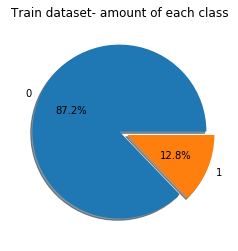

VALIDATION DATA: 

Unique values for 0: 943
Probability of class 0: 0.8707294552169899

Unique values for 1: 140
Probability of class 1: 0.12927054478301014



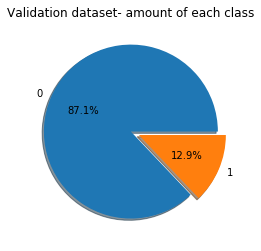

In [10]:
get_statictics(train_y)
get_statictics(validation_y, 'Validation')

Above diagrams show one important thing: __train and validation datasets are imbalanced__. <br>
In this case, model can learn how to predict "bird does not exist" perfectly and obtain nearly 90% accuracy.

<cite>"In the case of imbalanced data, majority classes dominate over minority classes, 
causing the machine learning classifiers to be more biased towards majority classes."</cite>

__Ideas to improve classification:__
- get the same number of "bird exists" and "bird does not exist" samples
- ensamble: the same as first idea but more than one time and randomly choose values for "bird does not exist"
- decision trees (forest)

Save train, validation and test data for checking accuracy on imbalanced data and then balancing data.

In [11]:
import pathlib

def create_not_existing_directory(directory: str):
    """
    Create not existing directory. 
    If directory exists, do nothing.
    :param directory: str
        directory to create
    """
    p = pathlib.Path(directory)
    if not p.is_dir():
        print(f'Creating directory: {directory} as it does not exist')
        p.mkdir(parents=True, exist_ok=True)

def save_datasets(data_file_mapping, directory='data/'):
    create_not_existing_directory(directory)
    for filename in data_file_mapping:
        np.save(pathlib.Path(directory + filename), data_file_mapping[filename])


In [12]:
train_test_dataset_filename_mapping = {
    'X_test': X_test,
    'X_train': X_train,
    'y_train': y_train
    
}

save_datasets(train_test_dataset_filename_mapping, directory='data/imbalanced/')

Creating directory: data/imbalanced/ as it does not exist


In [13]:
imbalanced_dataset_filename_mapping = {
    'X_train': train_X,
    'y_train': train_y,
    'X_validation': validation_X,
    'y_validation': validation_y,
}

save_datasets(imbalanced_dataset_filename_mapping, directory='data/imbalanced/splitted/')

Creating directory: data/imbalanced/splitted/ as it does not exist
